In [39]:
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import numpy as np

import matplotlib.pyplot as plt

pd.options.display.max_columns = None
uploadFormat = True
numOfChunks = 60

In [2]:
# the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/231023'

# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'

# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key wecan set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [3]:
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

def missing_data(series):
    return series == '-'

In [4]:
directory = os.fsencode(directory_in_str)

# we are going to iterate through the files
for fileBytes in os.listdir(directory):
    # get the name of the file, to see if it has the correct extention 
    filename = os.fsdecode(fileBytes)
    # and if it does, we process it
    if filename.endswith(".bin"):
        print('Checking {}'.format(filename))
        with open(os.path.join(directory, fileBytes), 'r') as file:
            line_count = 0
            # go through the file line by line
            # check the line isn't blank
            for line in file:
                if line == '\n':
                    continue
                if uploadFormat:
                    # this means that the file is in the funny format that you seem to get when
                    # uploading via Strings from the sensor to James's server. We have to convert 
                    # it into the normal format
                    while True:
                        line_part = file.readline()
                        if (line_part == '\n' or line_part == ''):
                            break
                        line = line.strip() + line_part.strip();
                # we need a line encramter so that we can tell the user where there are errors
                line_count = line_count + 1
                # and this is going to be the string into which we save the decoded ascii
                DecodedAsciiLine = ''

                # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                # although it might change so I've put it in a variable.
                for i in range(numOfChunks):
                    encChunk = line[i*32:(i*32)+32]
                    try:
                        CipherTextChunk = int(encChunk, 16)
                    except ValueError:
                        print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                            filename,line_count,i), 
                            file=sys.stderr)
                    PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                    # now decode the hex to ascii

                    # so the message ends with guff, so we have to look out for the nulll byte,
                    # which signifies the end.
                    # convert to a byte array
                    # we cut off the first two characters because they are the '0x' signifing hex
                    try:
                        PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                            filename,line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                    # look for the null character
                    nullLoc = PlaneByteArray.find(b'\00')

                    # if the location returned is 0 or higher then there is a null character in there
                    # and we must ignore everything after it
                    if (nullLoc > -1):
                        try:
                            AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                        except UnicodeDecodeError:
                            print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                filename, line_count, i), file=sys.stderr)
                            AsciiChunk = ''
                        except ValueError:
                            print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                filename, line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                    else:
                        try:
                            AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                        except UnicodeDecodeError:
                            print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                filename, line_count, i), file=sys.stderr)
                            AsciiChunk = ''
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                filename, line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                    # and concat the new block onto the exisiting string
                    DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                    # if we found the null character then we have reached the end of the message and can 
                    # break the loop
                    if (nullLoc > -1):
                        break
                # now we are going to try and decode the json string and convert it into a nested data structure
                try:
                    data.append(json.loads(DecodedAsciiLine.strip()))
                except ValueError:
                    # if it doesn't work, then try and output it.
                    print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                          file=sys.stderr
                         )
            continue
    else:
        continue

Checking 20231023_180210_8439.bin
Checking 20231023_180152_9086.bin


Error Decoding JSON in 20231023_180210_8439.bin, on line 6
Error Decoding JSON in 20231023_180210_8439.bin, on line 14
Error Decoding JSON in 20231023_180210_8439.bin, on line 18
Error Decoding JSON in 20231023_180210_8439.bin, on line 45
Error Decoding JSON in 20231023_180210_8439.bin, on line 63
Error Decoding JSON in 20231023_180210_8439.bin, on line 76
Error Decoding JSON in 20231023_180210_8439.bin, on line 77
Error Decoding JSON in 20231023_180210_8439.bin, on line 78
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 19, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 20, could not d

Error Decoding JSON in 20231023_180152_9086.bin, on line 142
Error Decoding JSON in 20231023_180152_9086.bin, on line 173
Error Decoding JSON in 20231023_180152_9086.bin, on line 177
Error Decoding JSON in 20231023_180152_9086.bin, on line 200
Error Decoding JSON in 20231023_180152_9086.bin, on line 203
Error Decoding JSON in 20231023_180152_9086.bin, on line 205
Error Decoding JSON in 20231023_180152_9086.bin, on line 214
Error in 20231023_180152_9086.bin, line 220, chunk 10, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 11, could not decrypt
Error in 20231023_180152_9086.bin, line 220, chunk 11, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 12, could not decrypt
Error in 20231023_180152_9086.bin, line 220, chunk 12, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 13, could not decrypt
Error in 20231023_180152_9086.bin, line 220, chunk 

Checking 20231023_175927_8875.bin
Checking 20231023_180242_9565.bin


Error Decoding JSON in 20231023_180242_9565.bin, on line 99
Error Decoding JSON in 20231023_180242_9565.bin, on line 100
Error Decoding JSON in 20231023_180242_9565.bin, on line 117
Error Decoding JSON in 20231023_180242_9565.bin, on line 129
Error Decoding JSON in 20231023_180242_9565.bin, on line 152
Error Decoding JSON in 20231023_180242_9565.bin, on line 157
Error Decoding JSON in 20231023_180242_9565.bin, on line 158
Error Decoding JSON in 20231023_180242_9565.bin, on line 182
Error Decoding JSON in 20231023_180242_9565.bin, on line 203
Error Decoding JSON in 20231023_180242_9565.bin, on line 206
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not decrypt
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not convert to ascii
Could not convert to int in 20231023_180242_9565.bin, line 210, chunk 16, could not decrypt
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not decrypt
Non-Hex Value found in line 20231023_1802

Checking 20231023_175911_4184.bin


Error Decoding JSON in 20231023_175911_4184.bin, on line 58
Error Decoding JSON in 20231023_175911_4184.bin, on line 67
Error Decoding JSON in 20231023_175911_4184.bin, on line 81
Error Decoding JSON in 20231023_175911_4184.bin, on line 102
Error in 20231023_175911_4184.bin, line 108, chunk 36, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 37, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 38, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 39, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 40, count not convert to ascii
Error Decoding JSON in 20231023_175911_4184.bin, on line 140
Error Decoding JSON in 20231023_175911_4184.bin, on line 146
Error Decoding JSON in 20231023_175911_4184.bin, on line 149
Error Decoding JSON in 20231023_175911_4184.bin, on line 171
Error Decoding JSON in 20231023_175911_4184.bin, on line 179
Error Decoding JSON in 20231023_175911_4184.

In [25]:
df = pd.DataFrame(data)

# putting everything into a single flat df.
# the FFT bins are named after the frequency they capture.

df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor),
           pd.DataFrame(df['FFT'].to_list(),columns = ['FFT.{}Hz'.format(i*43) for i in range(37)])
          ], axis=1)

df_flat = df_flat.mask(missing_data)
#data = data.convert_dtypes()
df_flat = df_flat.dropna()
#df_flat = df_flat.droplevel(level=0, axis=1)

In [26]:
df_flat

,datetime,fix,speed,angle,satellites,location.lat,location.long,location.alt,humidity,temp,heat_index,no2,c2h5ch,voc,co,atmos_enviro.AE_1.0,atmos_enviro.AE_2.5,atmos_enviro.AE_10.0,FFT.0Hz,FFT.43Hz,FFT.86Hz,FFT.129Hz,FFT.172Hz,FFT.215Hz,FFT.258Hz,FFT.301Hz,FFT.344Hz,FFT.387Hz,FFT.430Hz,FFT.473Hz,FFT.516Hz,FFT.559Hz,FFT.602Hz,FFT.645Hz,FFT.688Hz,FFT.731Hz,FFT.774Hz,FFT.817Hz,FFT.860Hz,FFT.903Hz,FFT.946Hz,FFT.989Hz,FFT.1032Hz,FFT.1075Hz,FFT.1118Hz,FFT.1161Hz,FFT.1204Hz,FFT.1247Hz,FFT.1290Hz,FFT.1333Hz,FFT.1376Hz,FFT.1419Hz,FFT.1462Hz,FFT.1505Hz,FFT.1548Hz
0,2023-10-23 16:28:38+00:00,True,0.55,151,10,5128.434082,233.809601,23.4,50,24,23.76,63,230,79,74,2,3,4,2.14,6.53,4.09,4.27,8.36,7.75,7.02,10.99,10.68,5.00,1.53,1.77,1.65,2.32,2.87,3.48,2.08,1.77,0.24,0.98,1.04,1.65,2.38,1.28,0.18,0.43,0.85,1.59,1.28,2.44,1.53,1.40,1.34,0.12,1.59,0.98,0.73
1,2023-10-23 16:28:43+00:00,True,0.37,123.349998,10,5128.434082,233.808899,23.4,66.2,16.8,16.26,63,236,79,78,2,3,4,0.18,6.04,10.19,9.28,11.17,6.71,5.55,7.02,2.75,3.36,1.22,1.04,0.55,1.65,3.72,4.33,1.59,0.73,0.85,1.46,1.04,1.95,2.20,0.61,1.10,1.04,0.24,0.12,0.06,0.31,0.00,0.43,0.55,1.04,0.49,1.28,0.55
2,2023-10-23 16:28:48+00:00,True,0.37,123.349998,13,5128.43457,233.808197,23.4,66.1,16.8,16.26,65,240,81,80,2,3,4,1.95,13.67,13.85,6.53,5.25,4.52,3.05,4.03,4.70,1.89,0.85,0.85,0.92,1.22,3.05,2.44,1.22,1.46,0.61,0.92,1.40,1.71,2.08,0.24,0.98,0.24,0.43,0.24,0.37,0.79,0.12,0.67,0.43,0.37,0.55,0.49,0.24
3,2023-10-23 16:28:53+00:00,True,0.14,255.210007,13,5128.43457,233.808106,23.4,66.1,16.8,16.26,67,232,81,74,2,3,5,5.68,6.23,2.87,1.71,2.38,5.55,9.52,10.07,11.66,6.71,1.95,0.55,1.04,0.73,3.23,3.36,0.31,1.34,0.18,0.79,0.67,0.73,1.89,1.71,0.92,1.40,1.34,0.85,0.37,0.49,0.18,0.67,1.16,1.40,0.92,1.59,1.28
4,2023-10-23 16:28:58+00:00,True,0.14,255.210007,12,5128.433594,233.808502,23.4,66,16.9,16.37,71,238,82,78,2,4,5,1.53,2.62,2.81,5.98,4.76,1.89,6.77,12.15,6.16,1.28,0.67,0.67,0.24,1.04,2.32,3.66,0.06,1.28,0.98,0.67,1.65,2.14,1.89,0.98,0.61,0.85,0.31,0.24,1.04,0.92,0.37,0.92,0.67,0.55,0.43,0.92,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2023-10-23 11:18:20+00:00,True,0.64,355.23999,9,5129.789063,235.480194,90.699997,68.5,16.6,16.1,57,187,101,68,2,3,5,6.90,6.90,10.07,9.03,2.44,3.85,3.42,5.86,5.13,1.16,0.55,0.67,0.92,0.49,2.69,3.78,2.01,0.24,0.12,0.43,1.04,1.16,1.46,1.10,1.46,0.61,0.31,0.43,0.43,0.67,0.92,1.46,0.79,0.79,0.79,0.55,0.49
854,2023-10-23 11:18:25+00:00,True,0.64,355.23999,10,5129.788574,235.479797,90.800003,68.6,16.6,16.11,56,187,100,68,2,3,4,2.32,1.65,3.91,2.44,3.48,5.25,4.27,6.65,5.37,3.11,3.17,0.85,0.49,1.16,2.62,4.46,2.50,1.16,0.55,0.92,0.73,0.61,0.49,0.49,0.24,0.18,0.49,0.18,0.55,0.31,0.43,0.73,0.92,0.79,0.85,0.31,0.37
855,2023-10-23 11:18:35+00:00,True,0.72,62.43,9,5129.789063,235.479401,91.099998,68.7,16.6,16.11,56,188,100,68,2,3,5,1.53,2.20,4.82,2.69,6.04,3.85,1.46,1.71,3.23,1.95,0.31,1.22,1.16,1.59,3.36,3.97,2.08,0.43,0.67,0.98,0.61,0.49,2.14,0.73,0.98,1.22,0.12,0.49,0.98,0.43,0.24,0.67,0.67,1.22,1.46,1.10,0.12
856,2023-10-23 11:18:40+00:00,True,0.98,299.529999,9,5129.789551,235.480392,91.099998,68.7,16.6,16.11,56,188,100,69,2,3,4,9.03,6.71,10.07,8.48,2.50,2.01,1.59,1.10,2.93,3.97,10.86,9.77,2.32,0.49,2.14,3.91,0.98,0.79,0.43,1.46,1.65,0.61,2.50,1.65,1.10,0.73,0.55,0.37,0.55,0.79,0.61,0.67,0.37,0.43,0.06,0.31,0.37


In [27]:
df_flat = gpd.GeoDataFrame(
    df_flat, 
    # geometry=gpd.points_from_xy(data['GPS']['location.long'].pipe(ddmm_to_degrees), 
    #                             data['GPS']['location.lat'].pipe(ddmm_to_degrees), 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [28]:
df_flat[['satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=200,
                           style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
                                                                  }
                                                                  
                                      }
                           )

In [29]:
df_flat[['satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('co', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=100,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

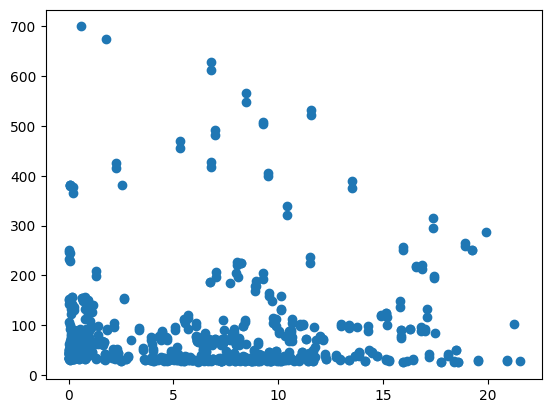

In [11]:
plt.scatter(x=df_flat['speed'], y=df_flat['no2'])

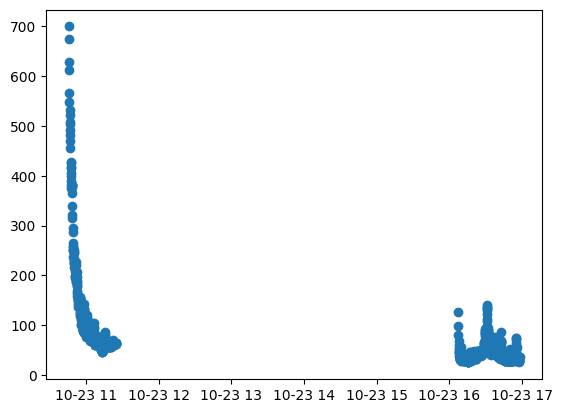

In [12]:
plt.plot(df_flat['datetime'],df_flat['no2'],'o')

In [45]:
df_flat.datetime

0     2023-10-23 16:28:38+00:00
1     2023-10-23 16:28:43+00:00
2     2023-10-23 16:28:48+00:00
3     2023-10-23 16:28:53+00:00
4     2023-10-23 16:28:58+00:00
                 ...           
853   2023-10-23 11:18:20+00:00
854   2023-10-23 11:18:25+00:00
855   2023-10-23 11:18:35+00:00
856   2023-10-23 11:18:40+00:00
857   2023-10-23 11:18:45+00:00
Name: datetime, Length: 853, dtype: datetime64[ns, UTC]

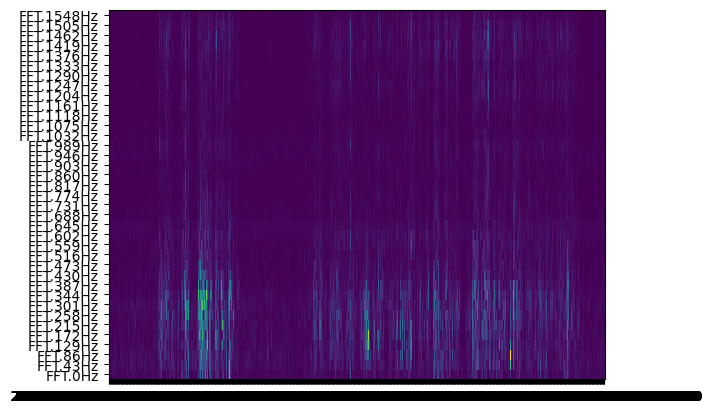

In [47]:
bins = df_flat.filter(like='FFT').columns

plt.pcolor(df_flat.filter(like='FFT').T)
plt.yticks(np.arange(0.5, bins.size, 1), bins)
plt.xticks(np.arange(0.5, len(df_flat.index), 1), df_flat.datetime)
plt.show()

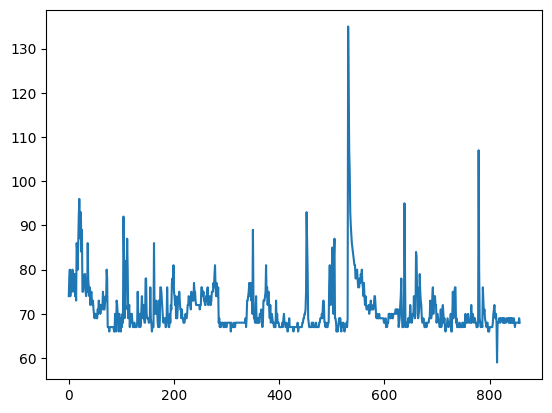

In [49]:
plt.plot(df_flat.co)
plt.show()